# Cookie Cats Mobile Game A/B Test Analysis

## 1. Goal of the analysis

1. **Impact of Gate Placement on Retention:**
- **Hypothesis**: Moving the gate from level 30 to level 40 improves player engagement, as measured by retention rates on day 1 (retention_1) and day 7 (retention_7).

2. **Long-Term Engagement and Gameplay Intensity:**
- **Hypothesis**: Players encountering the gate at level 40 will exhibit higher gameplay intensity (measured by sum_gamerounds) compared to players encountering it at level 30.

3. **Sample Ratio Mismatch (SRM) Impact:**
- **Hypothesis**: The observed discrepancy in group sizes does not significantly impact the analysis conclusions but may require adjustments or resampling.

4. **Statistical Significance of Retention Differences:**
- **Hypothesis**: Differences in 7-day retention rates are statistically significant, indicating an advantage for either gate placement.

5. **Distributional Differences in Gameplay:**
- **Hypothesis**: The gameplay distribution (sum_gamerounds) differs significantly between the two groups.

### 1.1 Context and Description:

In this project, we aim to evaluate the impact of moving the first gate in the Cookie Cats game from level 30 to level 40 on player retention and engagement. This A/B test randomly assigned players to two groups:
- Control Group (gate_30): Players encountered the first gate at level 30.
- Treatment Group (gate_40): Players encountered the first gate at level 40.

We will determine whether moving the gate improves player engagement, measured by retention rates on day 1 (**retention_1**) and day 7 (**retention_7**), as well as total game rounds played during the first 14 days (**sum_gamerounds**).

By addressing these aspects, the analysis aims to uncover actionable insights for the **game development team department** to assess the impact of gate placement on short-term and long-term retention rates and determine if early-game barriers encourage or discourage player engagement.

### 1.2 Target metric:

- Primary Target metric: The difference in 7-day **retention rate proportions** between **gate_30** and **gate_40**. The 7-day retention better reflects long-term engagement.

- Secondary metrics: 
    - The difference in 1-day **retention rate proportions** between **gate_30** and **gate_40**.
    - The difference in **distribution** of game rounds played (**sum_gamerounds**) to measure engagement intensity. This will allow us to compare the overall differences in player behavior between the groups.

### 1.3 First, we import the main libraries and create a consistent visual colormap we will use for the analysis.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import mannwhitneyu
from statsmodels.stats.proportion import confint_proportions_2indep

from utilities import (find_missing_values, find_outliers,
                       plot_gamerounds_boxplot, plot_retention_rates,
                       get_variant_summary, get_srm, binomial_test, prop_z_test,
                       bootstrap_ci, plot_gamerounds_hist, calculate_summary)

In [2]:
pd.set_option('display.max_colwidth', None)
plt.rcParams['figure.figsize'] = (10, 6)
colors=["#ca0020", "#f4a582", "#92c5de", "#0571b0"]
sns.set_theme(style="white")
sns.set_palette(sns.color_palette(colors))

## 2. Cleaning and inspecting data

### 2.1 We import the dataset and take a look at it

In [3]:
df = pd.read_csv("cookie_cats.csv")
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


### 2.2 We check for any missing values

In [4]:
find_missing_values(df)

,Zeroes,Empty Strings,NaN
userid,0,0,0
version,0,0,0
sum_gamerounds,3994,0,0
retention_1,50036,0,0
retention_7,73408,0,0


It seems like nearly 4 thousand players did not play a single round of the game - we will ignore the data from the players that didn't play any levels and never turned the game on within the 7 tracked days.

In [5]:
df = df[~((df["retention_1"] == False)
        & (df["retention_7"] == False)
        & (df["sum_gamerounds"] == 0)
        )]

### 2.3 We check for any duplicate entries

In [6]:
print(f"There are {df.duplicated().sum()} duplicate rows.")

There are 0 duplicate rows.


### 2.4 We check the datatypes

In [7]:
df.dtypes

userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object

In [8]:
df = df.astype({"version": "category"})

Since the version of the game represents the control or experiment group, we convert it to categorical data.

### 2.5 Let's check for any outliers in numerical fields using the IQR method

In [9]:
numeric = [feature for feature in df if df[feature].dtype in ["int64","float64"]]
outliers = find_outliers(df,numeric)
print(f"Outliers:\n{outliers}")

No outliers in 'userid'
Outliers in 'sum_gamerounds':
2        165
4        179
5        187
9        153
14       305
        ... 
90121    328
90125    186
90134    191
90150    253
90160    143
Name: sum_gamerounds, Length: 9616, dtype: int64

Outliers:
        userid  sum_gamerounds
2          377             165
4          488             179
5          540             187
9         1587             153
14        2218             305
...        ...             ...
90121  9991145             328
90125  9991408             186
90134  9991949             191
90150  9995412             253
90160  9996269             143

[9616 rows x 2 columns]


In [10]:
df.describe()

,userid,sum_gamerounds
count,8.630600e+04,86306.000000
mean,4.997095e+06,54.206254
std,2.883615e+06,199.072919
min,1.160000e+02,0.000000
25%,2.512700e+06,6.000000
50%,4.995124e+06,18.000000
75%,7.494322e+06,54.000000
max,9.999861e+06,49854.000000


We can see quite a few outliers in the game rounds field. Using a boxplot visualization we can get more information:

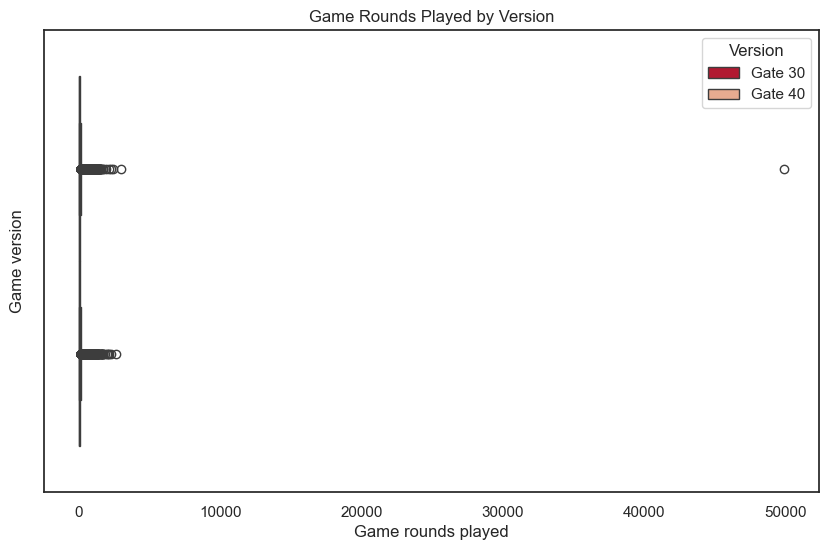

In [11]:
plot_gamerounds_boxplot(df)

It seems like the one instance of ~50k plays was either an error in data gathering, or the player used cheating methods. Nevertheless, we will remove this single value from the dataset.

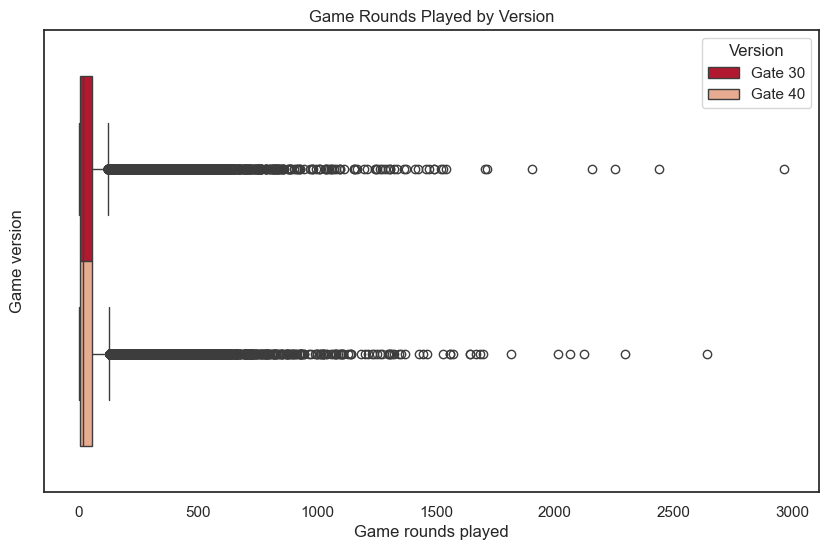

In [12]:
df = df[df["sum_gamerounds"] != df["sum_gamerounds"].max()]
plot_gamerounds_boxplot(df)

Now the data looks more proper. While we do have some outliers in the high field of 2000+ plays, it could be possible that these were just very dedicated players. Furthermore, we do not have enough information about the data to determine whether any in-game cheating mechanisms were used to deny this data.

### 2.7 Let's look at the retention rate by A/B groups:

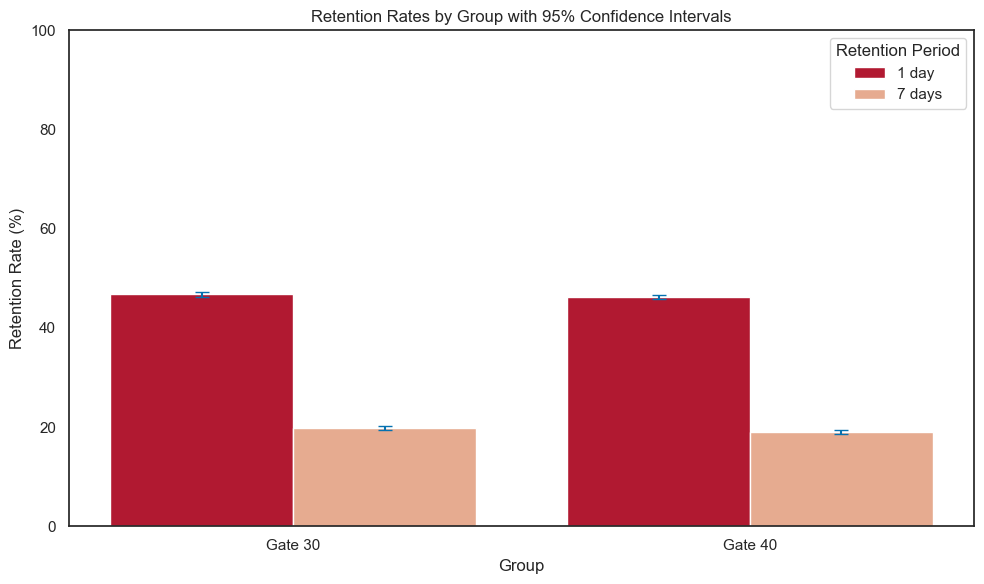

,version,metric,mean,MoE,lower_ci,upper_ci,std,count
0,Gate 30,retention_1,46.788734,0.472629,46.316105,47.261363,49.897354,42818
1,Gate 40,retention_1,46.264401,0.468636,45.795765,46.733037,49.860831,43487
2,Gate 30,retention_7,19.853800,0.377843,19.475957,20.231643,39.890397,42818
3,Gate 40,retention_7,19.037873,0.369004,18.668869,19.406878,39.260440,43487


In [13]:
retention_summary = calculate_summary(df,["version"],["retention_1","retention_7"], True)
plot_retention_rates(retention_summary)
retention_summary

Initially we can see that the 1-day retention rate differs by about 0.5% (higher in **gate_30** group), while the 7-day retention rate differs by about 0.8% (also higher in the **gate_30** group). To determine whether this is just by chance or if it statistically significantly impactful, we will do statistical analysis.

- Control group's 1-day retention rate's **95% CI** is between ~46.32% and ~47.26%
- Experiment group's 1-day retention rate's **95% CI** is between ~45.8% and ~46.73%
- Control group's 7-day retention rate's **95% CI** is between ~19.48% and ~20.23%
- Experiment group's 7-day retention rate's **95% CI** is between ~18.67% and ~19.41%

## 3. Calculations

### 3.1 What is our sample size and what are the version variation proportions?

In [14]:
total_samples, variant_counts, summary = get_variant_summary(df,"version")
summary

Total Sample Size: 86305



,Sample Size,Proportion
version,,
gate_30,42818,49.612421
gate_40,43487,50.387579


We can see quite a difference in sample size between the 2 groups (about 600 users difference, or ~0.4% off 50% for each side). To check whether this discrepancy is due to randomness or a bug, we will use the **Chi-Square test**.

### 3.2 Testing for SRM (sample ratio mismatch) using the **Chi-Square test** (using α level of 5%)

In [15]:
get_srm(total_samples, variant_counts)

Chi-Square statistic: 5.19
P-value: 0.0228
The p-value is less than 0.05, indicating a significant sample ratio mismatch.


Our **p-value** is quite low (0.0228), indicating that the variant proportions have a significant mismatch. Normally, this mismatch should not occur and may indicate wrongly collected data - if the data were collected by the development company, a recommendation would be to redo the experiment and extract the same number of control group samples as experiment group samples.

Nevertheles, to see whether the sample ratio mismatch may impact our analytical results, we will subset our data to create equal-sized groups for further testing. We will perform tests using the original data and the resampled groups, allowing us to see whether the SRM impacted the analysis results.

### 3.3 Performing statistical tests

**H0 (Null Hypothesis)**: p2 - p1 = 0 (There is no statistically significant difference the retention proportions between groups), where p2 is **group_40 7-day retention** and p1 is **group_30 7-day retention**

**Ha (Alternative Hypothesis)**: p2 - p1 ≠ 0

**α = 0.05 (5%)**

### 3.4 Binomial test - is gate_40 retention proportion significantly different from gate_30 retention proportion?

#### We will use the binomial test to compare observed successes in one group against a hypothesized probability derived from the pooled data.

#### Assumptions:

- Data independence: due to the nature of the dataset, players don't influence each other's retention
- Binary outcome: data has only 2 outcomes (True/False)
- Fixed number of observations: we know the number of observations
- Same probability: the probability for retention rates should not vary systematically

In [16]:
gate_30_retention7 = df[df["version"] == "gate_30"]["retention_7"]
gate_40_retention7 = df[df["version"] == "gate_40"]["retention_7"]
sub_gate_30_retention7 = gate_30_retention7.sample(42000, replace=False)
sub_gate_40_retention7 = gate_40_retention7.sample(42000, replace=False)

gate_30_retention1 = df[df["version"] == "gate_30"]["retention_1"]
gate_40_retention1 = df[df["version"] == "gate_40"]["retention_1"]
sub_gate_30_retention1 = gate_30_retention1.sample(42000, replace=False)
sub_gate_40_retention1 = gate_40_retention1.sample(42000, replace=False)

In [17]:
binom_result_7 = binomial_test(gate_40_retention7, gate_30_retention7)
print(f"7-day retention binomial test p-value: {binom_result_7.pvalue:.4f}")
binom_result_sub_7 = binomial_test(sub_gate_40_retention7, sub_gate_30_retention7)
print(f"Subset 7-day retention binomial test p-value: {binom_result_sub_7.pvalue:.4f}\n")

binom_result_1 = binomial_test(gate_40_retention1, gate_30_retention1)
print(f"1-day retention binomial test p-value: {binom_result_1.pvalue:.4f}")
binom_result_sub_1 = binomial_test(sub_gate_40_retention1, sub_gate_30_retention1)
print(f"Subset 1-day retention binomial test p-value: {binom_result_sub_1.pvalue:.4f}")

7-day retention binomial test p-value: 0.0330
Subset 7-day retention binomial test p-value: 0.0320

1-day retention binomial test p-value: 0.2773
Subset 1-day retention binomial test p-value: 0.2732


We can see that for 7-day retention, the **p-value** in both original data and sampled data is less than our alpha of 0.05, therefore we **reject the null hypothesis** - there is a significant difference in retention proportions between the control and experiment group in 7-day retention.

For 1-day retention, the **p-value** in both original data and sampled data is above our alpha treshold, leading us to **fail to reject the null hypothesis** - we do not have proof of significant difference between control and experiment group's 1-day retention proportion.

### 3.5 Proportions z-test - supporting our previous findings

#### Since the sample sizes are large, the proportions z-test is efficient because it assumes normality based on the Central Limit Theorem. It will also support our hypothesis testing validity due to the previously mentioned sample ratio mismatch.

#### Assumptions:

- Data independence: due to the nature of the dataset, players don't influence each other's retention
- Binary outcome: data has only 2 outcomes (True/False)
- Simple random samples - the experiment and control group was randomly assigned to each player
- Large enough sample size (at least 5 observations of True and False in each group)

In [18]:
stat7, p_value7 = prop_z_test(gate_30_retention7, gate_40_retention7)
print(f"7-day retention proportions z-test test p-value: {p_value7:.4f}")

sub_stat7, sub_p_value7 = prop_z_test(sub_gate_30_retention7, sub_gate_40_retention7)
print(f"Subset 7-day retention proportions z-test test p-value: {sub_p_value7:.4f}\n")

stat1, p_value1 = prop_z_test(gate_30_retention1, gate_40_retention1)
print(f"1-day retention proportions z-test test p-value: {p_value1:.4f}")

sub_stat1, sub_p_value1 = prop_z_test(sub_gate_30_retention1, sub_gate_40_retention1)
print(f"Subset 1-day retention proportions z-test test p-value: {sub_p_value1:.4f}")

7-day retention proportions z-test test p-value: 0.0025
Subset 7-day retention proportions z-test test p-value: 0.0024

1-day retention proportions z-test test p-value: 0.1226
Subset 1-day retention proportions z-test test p-value: 0.1196


The **proportions z-test** confirms the same results we got previously:

We can see that for 7-day retention, the **p-value** in both original data and sampled data is less than our alpha of 0.05, therefore we **reject the null hypothesis** - there is a significant difference in retention proportions between the control and experiment group in 7-day retention.

For 1-day retention, the **p-value** in both original data and sampled data is above our alpha treshold, leading us to **fail to reject the null hypothesis** - we do not have proof of significant difference between control and experiment group's 1-day retention proportion.

### 3.6 Confidence interval of retention proportion difference

### 3.6.1 To quantify the range of plausible values for the difference between the two proportions (gate_40 - gate_30), we will use confidence intervals

In [19]:
ci_low7, ci_high7 = confint_proportions_2indep(
    count1=gate_40_retention7.sum(), nobs1=len(gate_40_retention7),
    count2=gate_30_retention7.sum(), nobs2=len(gate_30_retention7)
)
ci_low1, ci_high1 = confint_proportions_2indep(
    count1=gate_40_retention1.sum(), nobs1=len(gate_40_retention1),
    count2=gate_30_retention1.sum(), nobs2=len(gate_30_retention1)
)

print(f"Confidence interval for difference in 7-day retention proportions: ({ci_low7*100:.2f}, {ci_high7*100:.2f})\n")

print(f"Confidence interval for difference in 1-day retention proportions: ({ci_low1*100:.2f}, {ci_high1*100:.2f})")

Confidence interval for difference in 7-day retention proportions: (-1.34, -0.29)

Confidence interval for difference in 1-day retention proportions: (-1.19, 0.14)


Since the function subtracts the first sample from the second, the negative confidence interval in the 7-day retention proportions suggests that the **experiment** group (Gate 40) has **lower** retention proportion, with a **95% CI** between -1.34% and -0.29%. Since the confidence interval does not include 0, we can once again confirm that the difference in proportions between the 2 groups is significant.

As for the 1-day retention proportions, the **95% CI** between -1.19% and 0.14% (overlapping 0) indicates that there is no significant difference in proportions between the 2 groups.

### 3.6.2 Confidence interval of retention proportion difference using bootstrap:

In [20]:
boot_ci_low7, boot_ci_high7 = bootstrap_ci(gate_30_retention7, gate_40_retention7)
print(f"Bootstrapped confidence interval for difference in 7-day retention proportions: ({boot_ci_low7*100:.2f}, {boot_ci_high7*100:.2f})\n")

boot_ci_low1, boot_ci_high1 = bootstrap_ci(gate_30_retention1, gate_40_retention1)
print(f"Bootstrapped confidence interval for difference in 1-day retention proportions: ({boot_ci_low1*100:.2f}, {boot_ci_high1*100:.2f})")

Bootstrapped confidence interval for difference in 7-day retention proportions: (-1.35, -0.29)

Bootstrapped confidence interval for difference in 1-day retention proportions: (-1.18, 0.13)


We can see that our bootstrapped confidence intervals for 7-day and 1-day retention proportions show nearly identical results as analytically calculated confidence intervals. This supports the robustness of our findings, regardless of the method used.

### 3.7 Checking the difference in **distribution** of game rounds played

**H0 (Null Hypothesis)**: The distributions of gamerounds in control and experiment groups are identical.

**Ha (Alternative Hypothesis)**: The distributions of gamerounds in the control and experiment groups are different (one group tends to have lower/higher gamerounds than the other).

**α = 0.05 (5%)**

Let's first check the data distribution of the game rounds played between versions

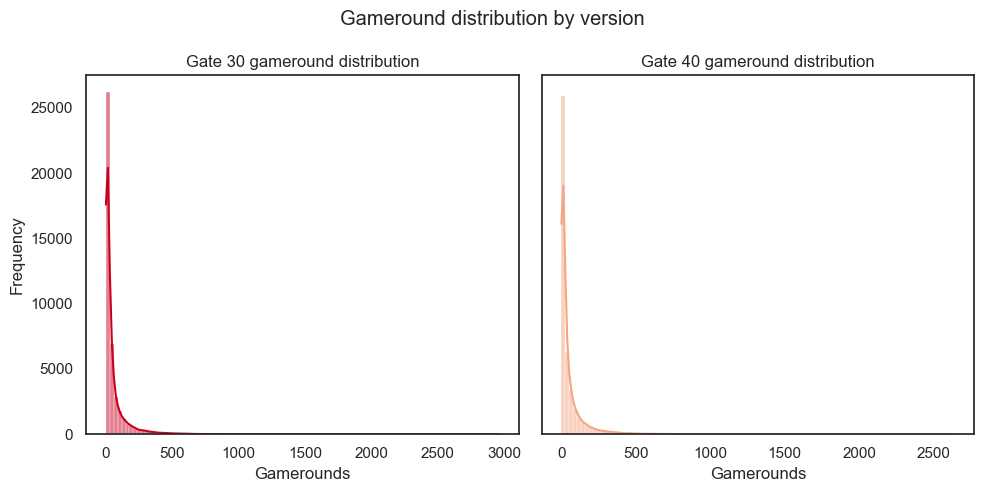

In [21]:
plot_gamerounds_hist(df)

We can see that the data does not follow a normal distribution. Therefore, we will use the **Mann-Whitney U** test, for which there are these assumptions:
- The variable must be continuous
- The data takes a non-normal distribution
- The data in both groups takes a similar shape
- The data in both groups should be independent of each other

Since we meet all of the assumptions, we can continue with the test.

In [22]:
gate_30_rounds = df[df["version"] == "gate_30"]["sum_gamerounds"]
gate_40_rounds = df[df["version"] == "gate_40"]["sum_gamerounds"]

stat, p_value = mannwhitneyu(gate_30_rounds, gate_40_rounds)
print(f"Mann-Whitney U test statistic: {stat:.4f}, p-value: {p_value:.4f}")

Mann-Whitney U test statistic: 936685573.0000, p-value: 0.1210


Since the **p-value** of 0.121 is higher than our **alpha** of 0.05, we **fail to reject** the null hypothesis. We do not have any proof that the distribution of gamerounds between the control and experimental groups have any significant difference.

## 4. Decision

1. **7-Day Retention Rates:**

- The **control** group (gate_30) shows a 7-day retention rate of **~19.48%-20.23%**, while the **experiment** group (gate_40) shows a rate of **~18.67%-19.41%**.
- The **difference** is statistically significant with a **p-value of 0.0025 (z-test)** and a **confidence interval of (-1.34%, -0.29%)**, indicating a lower retention for gate_40.
- **Decision:** Retain the gate at level 30 to optimize long-term player engagement.

2. **1-Day Retention Rates:**

- The **control** group (gate_30) shows a 1-day retention rate of **~46.32%-47.26%**, while the **experiment** group (gate_40) shows a rate of **~45.8%-46.73%**.
- The **difference** is not statistically significant with a **p-value of 0.1226 (z-test)**, suggesting that short-term engagement is unaffected by gate placement.
- **Decision:** Focus optimization efforts on improving long-term engagement rather than short-term retention, as there does not seem to be any difference between the 2 groups.

3. **Gameplay Intensity (sum_gamerounds):**

- The Mann-Whitney U test yields a **p-value of 0.121**, indicating no significant difference in gameplay intensity between the groups.
- **Decision:** Gate placement does not significantly influence overall gameplay distribution. No changes are needed here.

4. **Sample Ratio Mismatch:**

- A significant **p-value of 0.0228 (Chi-Square test)** indicates a mismatch in group sizes.
- Adjusting for this mismatch through resampling produced similar statistical results, confirming the robustness of findings.
- **Decision:** Proceed with current insights (recommended to improve data collection methods for further testing to avoid SRM).

### Insights for the game development team

- **Improve Control Group Features:** Since the control group (Gate 30) shows better 7-day retention, study what works in this group, like game mechanics.

- **Match Rewards:** The control group might offer better or more appealing rewards. Align experiment group rewards with the control group’s to boost engagement.

- **Balance Progression:** Players in the control group may have a smoother progression. Ensure the game’s challenges and rewards are well-paced and not rushed.

#### By applying these insights, the game development team can:

- Create less intrusive promotions that keep players engaged.
- Replicate successful features from the control group to improve retention.
- Improve the player experience by balancing rewards, progression, and promotions.

These changes will help increase long-term engagement and improve player retention.

## 5. Future improvements

1. **Exploration of Gameplay Trends:**
- Investigate whether other game features (e.g., rewards, difficulty spikes) impact retention and gameplay intensity.

2. **Extended Testing for Other Metrics:**
- Analyze the effects of gate placement on player satisfaction and spending behavior to derive more insights.

3. **Enhance segmentation analysis:**
- Additional demographic features, like player location, device type, or age, could further help the team tailor marketing strategies to regional or platform-specific needs.